# Ground Glass Opacity Segmentation Example

In this notebook, we will see an application of the implemented pipeline on the *COVID-19 CT Lung Infection and Segmentation Dataset*[1].

We have divided the workflow into two steps: segmentation of lung and segmentation of the GGO area.
Lung segmentation is a pivotal pre-processing step in many image analyses.

We identified the GGO as areas with a characteristic colour texture. To identify these regions, we used k-means clustering, grouping voxels by colour and texture similarity and identifying the tissue corresponding to each cluster.
We applied a series of image processing filters to obtain a high-dimensional feature space, including all these features for each voxel[2].

We will describe each pipeline step and visualize the intermediate results:
pre-processing step(lung extraction), construction of 4-dimensional feature space, preliminary training step (allows the estimation of the k-means centroids) and labelling phase. 

The notebook is structured as follows: 

 - Sample Download and organization
 - Pre-Processing and Lung Extraction
 - Construction of the feature space
 - Training: Centroids estimation
 - Labelling
 
Refer to the related article [2] for more information about the pipeline development, results and application. 

In [1]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

## Data loading

We will use the data provided by the *COVID-19 CT Lung and Infection Segmentation Dataset*[1].

This dataset contains 20 labelled COVID-19 CT scans. Left lung, right lung, and infections are labelled by two radiologists and verified by an experienced radiologist. 

These scans belong to coronacases and radiopedia studies. Unfortunately, the one collected by radiopedia are not supported by our segmentation pipeline since the CT scan were rescaled to 8-bit Gray Level(GL) images: This pipeline supports only Hounsfield Units(HU) scan.

From this dataset, we will use only the first three samples: coronacases_001 (C01), coronacases_002(C02) and coronacases_003(C03), that will form the training and testing sets: 
Training: C01, C03
Testing: C02

We will use the training set to estimate the k-means clustering centroids. We will use the testing sample and its ground truth label to visualize the segmentation steps and results. 

In [2]:
import zipfile
import urllib.request
from CTLungSeg.utils import read_image, write_volume

image_url = 'https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1'
label_url = 'https://zenodo.org/record/3757476/files/Lung_and_Infection_Mask.zip?download=1'

# Download the zip files containing the scans and the labels
urllib.request.urlretrieve(image_url, './Example_Scan.zip')
urllib.request.urlretrieve(label_url, './Ground_Truth.zip')

# unzip the files

with zipfile.ZipFile('./Ground_Truth.zip', 'r') as zip_ref:
    zip_ref.extractall('./Ground_Truth')

with zipfile.ZipFile('./Example_Scan.zip', 'r') as zip_ref:
    zip_ref.extractall('./Example_Scan')

In [3]:
#load the data
C01 = read_image(filename='./Example_Scan/coronacases_001.nii.gz')
C02 = read_image(filename='./Example_Scan/coronacases_002.nii.gz')
C03 = read_image(filename='./Example_Scan/coronacases_003.nii.gz')

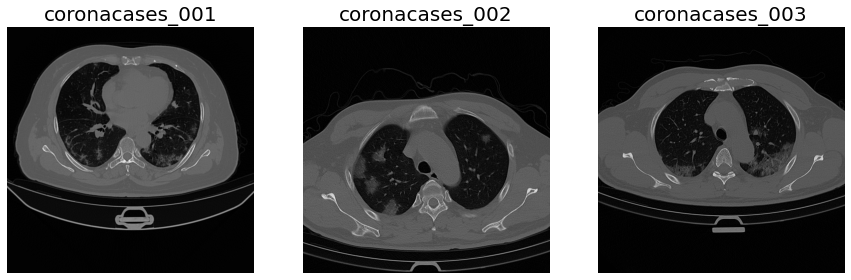

In [4]:
#Data Visualization 

# First of all convert the simple itk images to numpy array
A01 = sitk.GetArrayFromImage(C01)
A02 = sitk.GetArrayFromImage(C02)
A03 = sitk.GetArrayFromImage(C03)

# now flip them for a better visualization

A01 = np.flip(A01, axis=1)
A02 = np.flip(A02, axis=1)
A03 = np.flip(A03, axis=1)

# now visualize them

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

_ = ax[0].axis('off')
_ = ax[1].axis('off')
_ = ax[2].axis('off')

_ = ax[0].imshow(A01[150], cmap='gray')
_ = ax[0].set_title('coronacases_001', fontsize=20)

_ = ax[1].imshow(A02[150], cmap='gray')
_ = ax[1].set_title('coronacases_002', fontsize=20)

_ = ax[2].imshow(A03[150], cmap='gray')
_ = ax[2].set_title('coronacases_003', fontsize=20)

## Lung Extraction

Once we have obtained the examples scans, we are ready to start the segmentation pipeline. 

The first step is the segmentation of the lung region to remove all the unwanted body parts. That because the HU of these parts are very similar to ground glass ones, so are a potential source of the noise. 

To achieve this purpose, we have used a pre-trained U-Net[3] since rule-based approaches usually fail with severe Interstitial Lung Disease(ILD), as in this case. 

After the lung segmentation, we will also remove the blood vessels because they are a potential source of false positives. 

To achieve this purpose, we have computed the vesselness(likelihood of a voxel to be a blood vessel) using the Frangi filter and applied a threshold. 

We have constructed the *lung_extraction* function, which will perform all these steps on the training and testing set.

In [5]:
from lungmask.mask import apply
from CTLungSeg.utils import shift_and_crop
from CTLungSeg.method import apply_mask
from CTLungSeg.segmentation import remove_vessels


def lung_extraction(image):
    
    # apply the pre-trained network to find the lung mask
    lung_mask = apply(image)
    
    # since the NN distinguish between left and right lung by assign a different
    # label value to them, we have to remove this distinction
    lung_mask = (lung_mask != 0).astype(np.uint8)
    
    

    # The NN return as a mask a numpy array, we have to convert it to a SimpleITK image type
    #  with the  same physical information(voxel spacing, direction, etc) as the original image
    lung_mask = sitk.GetImageFromArray(lung_mask)
    _ = lung_mask.CopyInformation(image)
    
       
    # now apply the mask to the input image
    masked = apply_mask(image=image, mask=lung_mask, outside_value=-1000)
    # now start to remove the vessels
    wo_vessels = remove_vessels(image=masked)
    result = shift_and_crop(image=wo_vessels)
    
    return result

In [6]:
#Now perform this step to each of the considered samples.

C01L = lung_extraction(image=C01)
C02L = lung_extraction(image=C02)
C03L = lung_extraction(image=C03)

INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 6/6 [00:00<00:00, 57.89it/s]


INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 7/7 [00:00<00:00, 64.10it/s]


INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 4/4 [00:00<00:00, 103.49it/s]


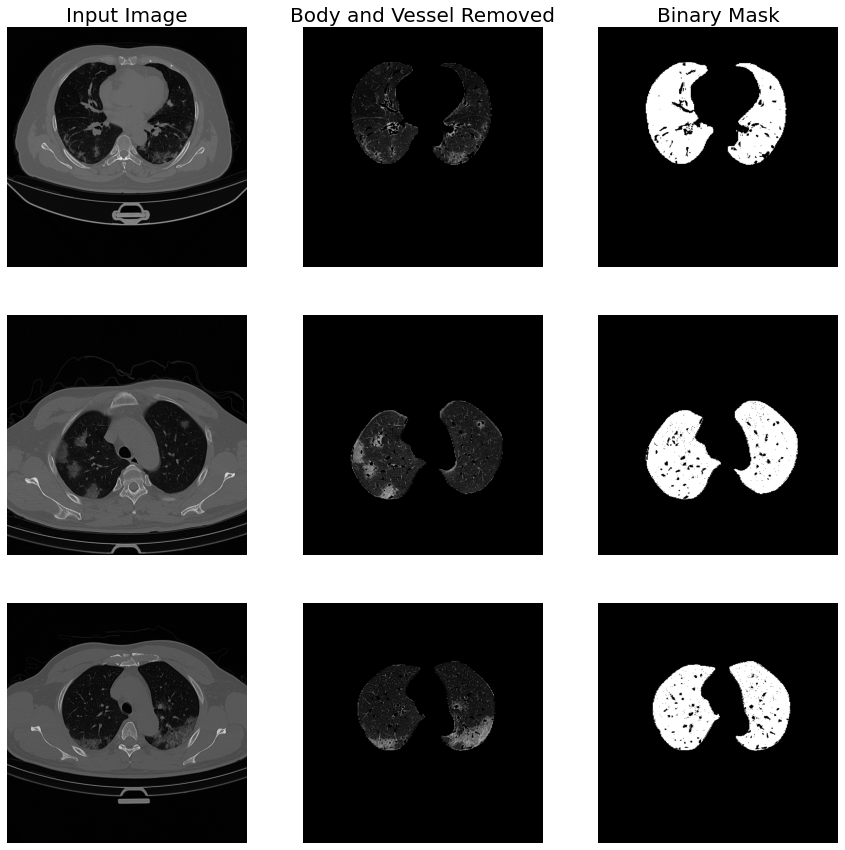

In [8]:
# display the results

# first convert them into numpy array
A01L = sitk.GetArrayFromImage(C01L)
A02L = sitk.GetArrayFromImage(C02L)
A03L = sitk.GetArrayFromImage(C03L)


# and make them correctly oriented
A01L = np.flip(A01L, axis=1)
A02L = np.flip(A02L, axis=1)
A03L = np.flip(A03L, axis=1)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# setting labels
_ = ax[0][0].set_title('Input Image', fontsize=20)
_ = ax[0][1].set_title('Body and Vessel Removed', fontsize=20)
_ = ax[0][2].set_title('Binary Mask', fontsize=20)

# display coronacases_001
_ = ax[0][0].axis('off')
_ = ax[0][1].axis('off')
_ = ax[0][2].axis('off')

_ = ax[0][0].imshow(A01[150], cmap='gray')
_ = ax[0][1].imshow(A01L[150], cmap='gray')
_ = ax[0][2].imshow(A01L[150] != 0, cmap='gray')


# display coronacases_002
_ = ax[1][0].axis('off')
_ = ax[1][1].axis('off')
_ = ax[1][2].axis('off')

_ = ax[1][0].imshow(A02[150], cmap='gray')
_ = ax[1][1].imshow(A02L[150], cmap='gray')
_ = ax[1][2].imshow(A02L[150] != 0, cmap='gray')

# display coronacases_003
_ = ax[2][0].axis('off')
_ = ax[2][1].axis('off')
_ = ax[2][2].axis('off')

_ = ax[2][0].imshow(A03[150], cmap='gray')
_ = ax[2][1].imshow(A03L[150], cmap='gray')
_ = ax[2][2].imshow(A03L[150] != 0, cmap='gray')



## Feature Computation

Before training and labelling, we have to compute the image features to incorporates many image information. We will build a multichannel image in which each channel represents a different filter. 
The used filters are: 

   - median blurring
   - std deviation filter
   - gamma correction
   - local histogram equalization
   
We have normalized each image according to the mean and standard deviation of voxel distribution.
Notice that the fifth channel containing the lung mask. This channel allows the exclusion of the background voxels: its cluster is overrepresented and may lead to biases on centroid computation.

In [9]:
from CTLungSeg.utils import normalize
from CTLungSeg.method import std_filter, adaptive_histogram_equalization
from CTLungSeg.method import median_filter, adjust_gamma, threshold


def compute_filters(img):
    
    he = normalize(adaptive_histogram_equalization(image=img, radius=2))
    med = normalize(median_filter(img=img, radius=3))
    std = normalize(std_filter(image=img, radius=3))
    gamma = normalize(adjust_gamma(image=img, gamma=1.5))
    mask = threshold(image=img, upper=4000, lower=1)

    he = sitk.GetArrayFromImage(he)
    med = sitk.GetArrayFromImage(med)
    std = sitk.GetArrayFromImage(std)
    gamma = sitk.GetArrayFromImage(gamma)
    mask = sitk.GetArrayFromImage(mask)

    stk = np.stack([he, med, gamma, std, mask], axis=-1)
    
    return stk

In [10]:
# for each sample, computes the multi-channel image.

MC01 = compute_filters(img=C01L)
MC02 = compute_filters(img=C02L)
MC03 = compute_filters(img=C03L)

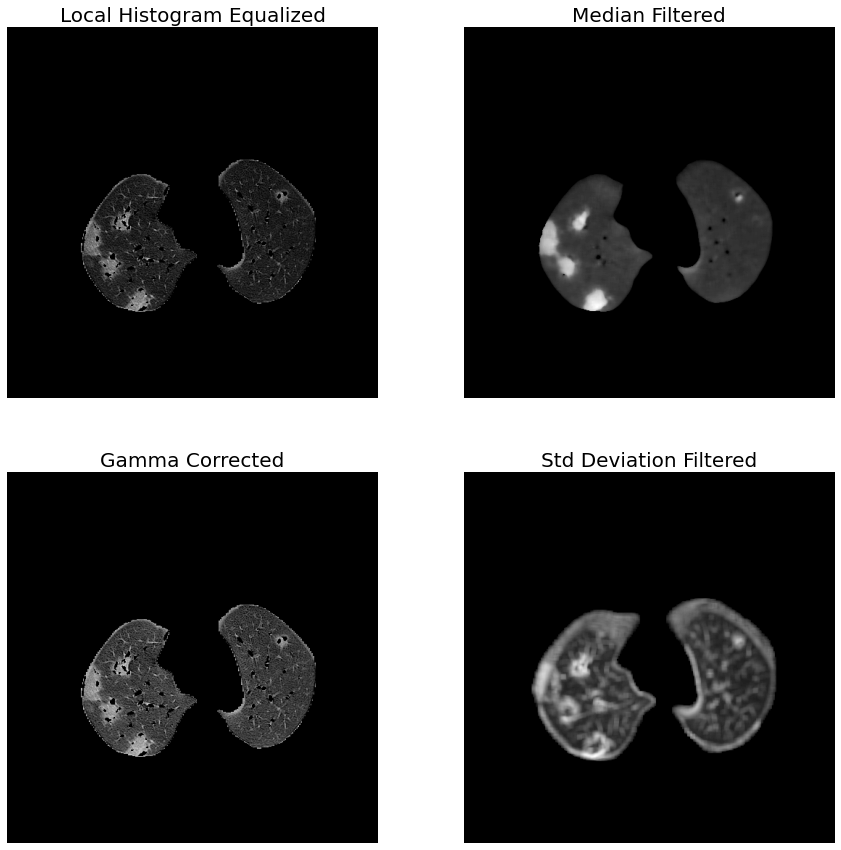

In [11]:
# prepare data for the visualization
HE = np.flip(MC02[:, :, :, 0], axis=1)
ME = np.flip(MC02[:, :, :, 1], axis=1)
GC = np.flip(MC02[:, :, :, 2], axis=1)
SD = np.flip(MC02[:, :, :, 3], axis=1)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

_ = ax[0][0].axis('off')
_ = ax[0][0].imshow(HE[150], cmap='gray')
_ = ax[0][0].set_title('Local Histogram Equalized', fontsize=20)

_ = ax[0][1].axis('off')
_ = ax[0][1].imshow(ME[150], cmap='gray')
_ = ax[0][1].set_title('Median Filtered', fontsize=20)

_ = ax[1][0].axis('off')
_ = ax[1][0].imshow(GC[150], cmap='gray')
_ = ax[1][0].set_title('Gamma Corrected', fontsize=20)

_ = ax[1][1].axis('off')
_ = ax[1][1].imshow(SD[150], cmap='gray')
_ = ax[1][1].set_title('Std Deviation Filtered', fontsize=20)


## Training

The training step allows the centroid estimation using k-means clustering.
We have used the features extracted from *coronacases_001* and *coronacases_003* samples. We have concatenated the images into a single stack.  
k-means clustering is sensitive to the centroid initialization, so we have split the set into many subsets, performing the clustering on each.
Then we have chosen the most suitable centroid set. 

In [12]:
# form the training set

training_set = np.concatenate([MC01, MC03], axis=0)

In [14]:
import cv2
from CTLungSeg.segmentation import kmeans_on_subsamples
from CTLungSeg.utils import shuffle_and_split

# kmeans clustering stopping criteria
stop_criteria = (cv2.TERM_CRITERIA_EPS
                    + cv2.TERM_CRITERIA_MAX_ITER, 10, .001)

subsamples = shuffle_and_split(data=training_set, number_of_subarrays=15)

ret, centers = kmeans_on_subsamples(imgs=subsamples, 
                                   n_centroids=5, #number of centroids 
                                   stopping_criteria=stop_criteria, 
                                   centr_init=cv2.KMEANS_PP_CENTERS,#centroid initialization technique
                                   weight=True # to exclude the background voxels from clustering
                                   )
# the best centroid set is the one that form cluster with the high intra-cluster similarity and inter-cluster difference. 
best_centroids = centers[np.argmin(ret)]
best_centroids = best_centroids[best_centroids[:, 0].argsort()] # sort the centroids

100%|██████████| 15/15 [00:26<00:00,  1.79s/it]


## Labelling

Once we have extracted the lung and removed the vessels, we are ready to identify the ground glass area. We will use a set of pre-traied centroid.  
  
Each voxel is assigned to the class of the nearest centroid. The nearest centroid is defined as the one that minimize the euclidean distance:

\\[class = \arg\,\min_S \sum^k_{i=1}\sum_{x\in S} ||x - \mu_i|| \\]

where \\(S\\) is the set of all the image voxels and \\(\mu_i\\) is the \\(i_{th}\\) centroid.


In [15]:
from CTLungSeg.segmentation import imlabeling


labeled_image = imlabeling(image=MC02[:, :, :, :-1], centroids=best_centroids, weight=MC02[:, :, :, -1])

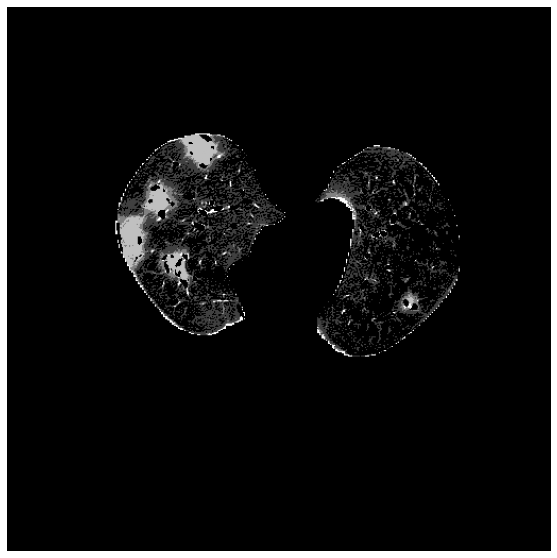

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
_ = ax.axis('off')
_ = ax.imshow(labeled_image[150], cmap='gray')

In [17]:
labeled_image = (labeled_image == 3).astype(np.uint8)

In [18]:
ground_truth = read_image('./Ground_Truth/coronacases_002.nii.gz')
ground_truth = sitk.GetArrayFromImage(ground_truth)
ground_truth = np.flip(ground_truth, axis=1)
labeled_image = np.flip(labeled_image, axis=1)

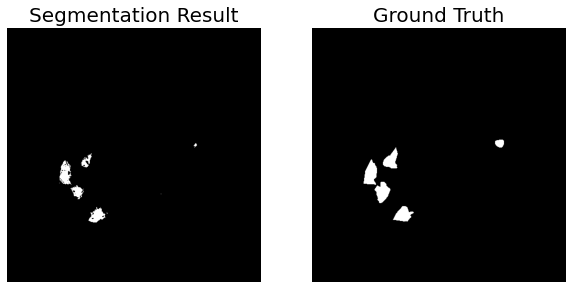

In [19]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

_ = ax[0].axis('off')
_ = ax[0].imshow(labeled_image[150], cmap='gray')
_ = ax[0].set_title('Segmentation Result', fontsize=20)

_ = ax[1].axis('off')
_ = ax[1].imshow(ground_truth[150]==3, cmap='gray')
_ = ax[1].set_title('Ground Truth', fontsize=20)

## References

<blockquote>1 - Ma Jun, Ge Cheng, Wang Yixin, An Xingle, Gao Jiantao, Yu Ziqi, Zhang Minqing, Liu Xin, Deng Xueyuan, Cao Shucheng, Wei Hao, Mei Sen, Yang Xiaoyu, Nie Ziwei, Li Chen, Tian Lu, Zhu Yuntao, Zhu Qiongjie, Dong Guoqiang, He Jian. COVID-19 CT Lung and Infection Segmentation Dataset (Verson 1.0) [Data set]. Zenodo. (2020). https://doi.org/10.5281/zenodo.3757476
</blockquote>

<blockquote>2 - Biondi R, Curti N, Coppola F, Giampieri E, Vara G, Bartoletti M, Cattabriga A, Cocozza MA, Ciccarese F, De Benedittis C, Cercenelli L, Bortolani B, Marcelli E, Pierotti L, Strigari L, Viale P, Golfieri R, Castellani G. Classification Performance for COVID Patient Prognosis from Automatic AI Segmentation—A Single-Center Study. Applied Sciences. 2021; 11(12):5438. https://doi.org/10.3390/app11125438
</blockquote>

<blockquote>3- Hofmanninger, J., Prayer, F., Pan, J. et al. Automatic lung segmentation in routine imaging is primarily a data diversity problem, not a methodology problem. Eur Radiol Exp 4, 50 (2020). https://doi.org/10.1186/s41747-020-00173-2. </blockquote>


